In [1]:
!git clone https://github.com/SpatialVision/Orient-Anything.git

Cloning into 'Orient-Anything'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 77 (delta 25), reused 56 (delta 13), pack-reused 0 (from 0)
Receiving objects: 100% (77/77), 2.68 MiB | 5.81 MiB/s, done.
Resolving deltas: 100% (25/25), done.


In [2]:
!pip install rembg
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 491.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.2 MB/s eta 0:00:00


In [3]:
import sys
sys.path.insert(0, "Orient-Anything")  # so Python finds the local modules first


In [4]:
!cp -r Orient-Anything/assets .

In [5]:
from vision_tower import DINOv2_MLP
from inference    import get_3angle, get_3angle_infer_aug

In [6]:
import gc
import torch
from transformers import AutoModelForZeroShotObjectDetection, AutoProcessor

BOX_THRESHOLD = 0.4
TEXT_THRESHOLD = (0.3,)


class GroundingDINOModelWrapper:
    def __init__(
        self, model_id="IDEA-Research/grounding-dino-tiny", device: str = "cuda"
    ):
        self.model_id = model_id
        self.device = device
        self.processor = None
        self.model = None

    def load(self):
        self.processor = AutoProcessor.from_pretrained(self.model_id)
        self.model = AutoModelForZeroShotObjectDetection.from_pretrained(
            self.model_id
        ).to(self.device)

    def unload(self):
        if self.model is not None:
            self.model.to("cpu")
            del self.model
            self.model = None
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    def detect(self, img, objects: list):

        # dino expects input in str in format: obj1. obj2 obj3.
        text_dino = ". ".join(objects) + "."

        inputs = self.processor(images=img, text=text_dino, return_tensors="pt").to(
            self.device
        )
        with torch.no_grad():
            outputs = self.model(**inputs)

        detection_results = self.processor.post_process_grounded_object_detection(
            outputs,
            inputs.input_ids,
            box_threshold=0.4,
            text_threshold=0.3,
            target_sizes=[img.size[::-1]],
        )[0]
        return detection_results["boxes"].cpu().numpy().tolist(), detection_results["labels"]


In [7]:
import gc
from typing import Optional

import torch
from transformers import SamModel, SamProcessor

class SAMModelWrapper:
    def __init__(self, model_id="facebook/sam-vit-base", device: str = "cuda"):
        self.model_id = model_id
        self.device = device
        self.processor = None
        self.model = None

    def load(self):
        self.processor = SamProcessor.from_pretrained(self.model_id)
        self.model = SamModel.from_pretrained(self.model_id).to(self.device)

    def unload(self):
        if self.model is not None:
            self.model.to("cpu")
            del self.model
            self.model = None
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    def get_masks(self, img, boxes):
        if len(boxes) == 0:
            # no boxes → no masks
            H, W = img.height, img.width
            return torch.zeros((0, H, W), dtype=torch.bool)

        sam_inputs = self.processor(
            images=img,
            input_boxes=[boxes],         # now boxes is non‐empty
            return_tensors="pt"
        ).to(self.device)

        with torch.no_grad():
            sam_outputs = self.model(**sam_inputs)

        masks = self.processor.post_process_masks(
            sam_outputs.pred_masks,
            original_sizes=sam_inputs.original_sizes,
            reshaped_input_sizes=sam_inputs.reshaped_input_sizes,
        )[0]

        # pick highest‐IoU mask per object
        return masks[:, 0, :, :]


In [22]:
import math
import gc
import torch

from PIL import Image
from transformers import DepthProForDepthEstimation, DepthProImageProcessorFast


class DepthProModelWrapper:
    def __init__(self, model_id: str = "apple/DepthPro-hf", device: str = "cuda"):
        self.model_id = model_id
        self.device = device
        self.processor = None
        self.model = None

    def load(self):
        self.processor = DepthProImageProcessorFast.from_pretrained(self.model_id)
        self.model = DepthProForDepthEstimation.from_pretrained(self.model_id).to(
            self.device
        )

    def unload(self):
        if self.model is not None:
            self.model.to("cpu")
            del self.model
            self.model = None
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    def estimate_depth(self, img: Image.Image):
        psize = self.model.config.patch_size
        min_ratio = min(self.model.config.scaled_images_ratios)
        min_size = math.ceil(psize / min_ratio)
        H, W = img.height, img.width

        if min(H, W) < min_size:
            scale = min_size / min(H, W)
            img_proc = img.resize(
                (math.ceil(W * scale), math.ceil(H * scale)), Image.BICUBIC
            )
        else:
            img_proc = img

        inputs = self.processor(images=img_proc, return_tensors="pt").to(self.device)
        with torch.no_grad():
            out = self.model(**inputs)
        results = self.processor.post_process_depth_estimation(
            out, target_sizes=[(H, W)]
        )
        print(results)
        depth_map = results[0]["predicted_depth"].squeeze().cpu().numpy()
        return depth_map, results[0]["focal_length"]


In [ ]:

import os
import gc
import torch
from PIL import Image
from transformers import AutoImageProcessor
from huggingface_hub import hf_hub_download
from vision_tower import DINOv2_MLP
from inference import get_3angle, get_3angle_infer_aug

class OrientAnythingModelWrapper:
    _WEIGHT_FILES = {
        "small": "cropS/dino_weight.pt",
        "base":  "cropB/dino_weight.pt",
        "large": "croplargeEX2/dino_weight.pt",
    }
    _BACKBONE_IDS = {
        "small": "facebook/dinov2-small",
        "base":  "facebook/dinov2-base",
        "large": "facebook/dinov2-large",
    }
    _IN_DIMS = {"small": 384, "base": 768, "large": 1024}
    _OUT_DIM = 360 + 180 + 180 + 2

    def __init__(self, model_size="large", device="cuda", cache_dir=None):
        assert model_size in self._WEIGHT_FILES, f"Unsupported model_size {model_size}"
        self.model_size = model_size
        self.device = device
        self.cache_dir = cache_dir or os.getcwd()
        self.repo_id = "Viglong/Orient-Anything"
        self.dino_mlp = None
        self.processor = None

    def load(self):
        weight_path = hf_hub_download(
            repo_id=self.repo_id,
            filename=self._WEIGHT_FILES[self.model_size],
            cache_dir=self.cache_dir,
            repo_type="model",
        )
        self.dino_mlp = DINOv2_MLP(
            dino_mode=self.model_size,
            in_dim=self._IN_DIMS[self.model_size],
            out_dim=self._OUT_DIM,
            evaluate=True,
            mask_dino=False,
            frozen_back=False,
        )
        state = torch.load(weight_path, map_location="cpu")
        self.dino_mlp.load_state_dict(state)
        self.dino_mlp = self.dino_mlp.to(self.device).eval()

        backbone_id = self._BACKBONE_IDS[self.model_size]
        self.processor = AutoImageProcessor.from_pretrained(
            backbone_id, cache_dir=self.cache_dir
        )

    def unload(self):
        if self.dino_mlp is not None:
            self.dino_mlp.to("cpu")
            del self.dino_mlp, self.processor
            self.dino_mlp = None
            self.processor = None
            torch.cuda.empty_cache()
            gc.collect()

    def estimate_orientation(self, img: Image.Image, boxes, masks=None, depth_map=None, use_tta=False):
        results = []
        for box in boxes:
            x0, y0, x1, y1 = map(int, box)
            crop = img.crop((x0, y0, x1, y1)).convert("RGB")
            if use_tta:
                angles = get_3angle_infer_aug(crop, self.dino_mlp, self.processor, self.device)
            else:
                angles = get_3angle(crop, self.dino_mlp, self.processor, self.device)
                angles[0] = angles[0] + 180 if angles[0] < 0 else angles[0] - 180
                angles[1] = 0
                angles[2] = 0
            results.append(tuple(angles.cpu().tolist()))
        return results


In [ ]:

"""
ExternalVisionModule is responsible for all scene abstraction flow. From raw image, to list of objects' poses (position + orientation)
"""
from PIL import Image
from typing import List
import numpy as np

class ExternalVisionModule:
    def __init__(self, device="cuda", orient_size="large"):
        self.device = device
        self.dino = GroundingDINOModelWrapper(device=device)
        self.sam = SAMModelWrapper(device=device)
        self.depthpro = DepthProModelWrapper(device=device)
        self.orient = OrientAnythingModelWrapper(model_size=orient_size, device=device)

    def abstract_scene(self, img: Image.Image, objects: List[str]) -> dict:
        # 1) Detection
        self.dino.load()
        boxes, labels = self.dino.detect(img, objects)
        self.dino.unload()

        # 2) Segmentation
        self.sam.load()
        masks = self.sam.get_masks(img, boxes)
        self.sam.unload()

        # 3) Depth
        self.depthpro.load()
        depth_map, focal_length = self.depthpro.estimate_depth(img)
        self.depthpro.unload()

        # 4) Orientation
        self.orient.load()
        orientations = self.orient.estimate_orientation(
            img, boxes, masks=masks, depth_map=depth_map
        )
        self.orient.unload()

        # 5) Compute median positions
        masks_np = masks.cpu().numpy()
        positions = []
        for m in masks_np:
            ys, xs = np.nonzero(m)

            def image_to_camera_coords(x, y, z, f, w, h):
                x_centered = x - (w / 2)
                y_centered = -y + (h / 2)
  
                X = (x_centered * z) / f
                Y = (y_centered * z) / f

                return X, Y

            w, h = img.size
            f = focal_length
            x_pixel, y_pixel = np.median(xs), np.median(ys)
            z_depth = np.median(depth_map[m.astype(bool)])

            X_cam, Y_cam = image_to_camera_coords(x_pixel, y_pixel, z_depth, f, w, h)
            positions.append((
                float(Y_cam),
                float(X_cam),
                float(z_depth)
            ))



        return {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "depth_map": depth_map,
            "positions": np.array(positions),
            "orientations": np.array(orientations),
        }


In [29]:

import requests
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
import torch

# 1. Pull an image from a URL
url = "https://m.media-amazon.com/images/I/81mH+mbFefS.jpg"
resp = requests.get(url)
img = Image.open(BytesIO(resp.content)).convert("RGB")

# 2. Which objects to detect
objects = ["tank", "red ninja", "blue lizard"]

# 3. Run the full pipeline
device = "cuda" if torch.cuda.is_available() else "cpu"
evm = ExternalVisionModule(device=device)
res = evm.abstract_scene(img, objects)


[{'predicted_depth': tensor([[7.5979, 8.2345, 9.4181,  ..., 8.7178, 8.5028, 8.3653],
        [8.8300, 9.0088, 9.2911,  ..., 8.6746, 8.7207, 8.7517],
        [9.2772, 9.2713, 9.2625,  ..., 8.7809, 8.8058, 8.8226],
        ...,
        [3.9143, 3.8991, 3.8765,  ..., 3.8050, 3.8147, 3.8212],
        [3.9004, 3.8911, 3.8774,  ..., 3.7956, 3.8393, 3.8690],
        [3.8668, 3.8890, 3.9228,  ..., 3.7888, 3.8398, 3.8745]],
       device='cuda:0'), 'field_of_view': tensor(18.7417, device='cuda:0'), 'focal_length': tensor(7756.3530, device='cuda:0')}]


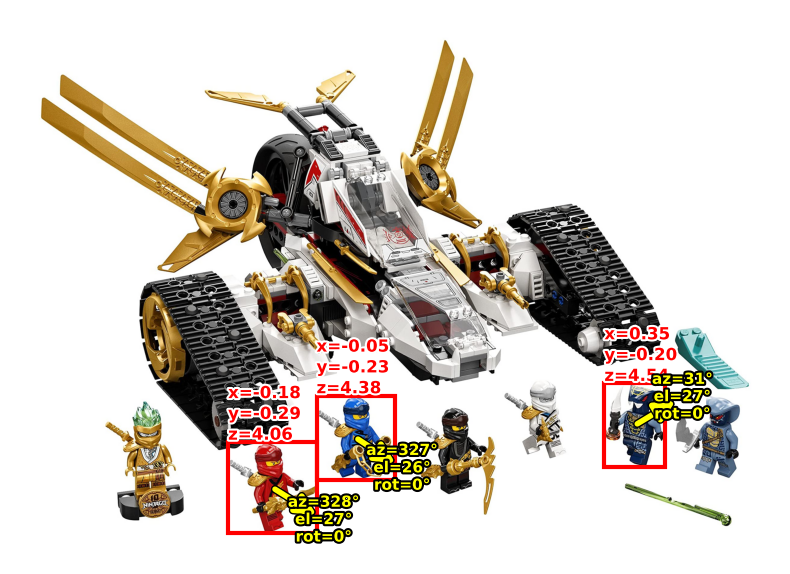

In [ ]:
import math
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import matplotlib.patheffects as pe

# 4. Visualize boxes + depth + high-contrast orientation arrows
boxes        = res["boxes"]
depths       = res["positions"][:, 2]
xs           = res["positions"][:, 1]
ys           = res["positions"][:, 0]
orientations = res["orientations"]  # (az, el, rot, conf)

fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(img)

for (x0, y0, x1, y1), z, x, y, (az, el, rot, conf) in zip(boxes, depths, xs, ys, orientations):
    # draw bbox
    rect = plt.Rectangle((x0, y0), x1-x0, y1-y0,
                         fill=False, edgecolor="red", linewidth=3, zorder=1)
    ax.add_patch(rect)
    ax.text(x0, y0 - 8, f"x={x:.2f}\ny={y:.2f}\nz={z:.2f}", color="red", fontsize=12, weight="bold",
            path_effects=[pe.Stroke(linewidth=3, foreground="white"), pe.Normal()],
            zorder=2)

    # compute center and dynamic arrow length
    cx = (x0 + x1) / 2
    cy = (y0 + y1) / 2
    box_w = x1 - x0
    box_h = y1 - y0
    L = max(box_w, box_h) * 0.6  # 60% of max dimension

    # arrow vector for azimuth (y-axis downwards)
    dx =  L * math.cos(math.radians(az))
    dy = -L * math.sin(math.radians(az))

    # high-contrast arrow
    arrow = FancyArrowPatch(
        (cx, cy), (cx + dx, cy + dy),
        arrowstyle='-|>',
        mutation_scale=30,        # big arrow head
        linewidth=4,              # thick shaft
        color="yellow",
        zorder=3
    )
    # add black outline
    arrow.set_path_effects([pe.Stroke(linewidth=6, foreground="black"), pe.Normal()])
    ax.add_patch(arrow)

    # label angles just beyond arrow head
    label_x = cx + dx * 1.1
    label_y = cy + dy * 1.1
    ax.text(label_x, label_y,
            f"az={az:.0f}°\nel={el:.0f}°\nrot={rot:.0f}°",
            fontsize=11, weight="bold", color="yellow",
            va="center", ha="center",
            path_effects=[pe.Stroke(linewidth=3, foreground="black"), pe.Normal()],
            zorder=4)

ax.axis("off")
plt.tight_layout()
plt.show()
